In [24]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import joblib
from datetime import datetime
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, 
                           classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Ready for SmartBin analysis!")


✅ All libraries imported successfully!
📊 Ready for SmartBin analysis!


In [25]:
# Dataset paths
dataset_dir = Path(r"F:\SmartBin\dataset")
general_dir = dataset_dir / "General"
recycle_dir = dataset_dir / "Recycle"

# Image processing parameters
IMG_SIZE = (128, 128)  # Target image size
image_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"}

# Class names
class_names = ['General', 'Recycle']

print(f"📁 Dataset directory: {dataset_dir}")
print(f"📁 General directory: {general_dir}")
print(f"📁 Recycle directory: {recycle_dir}")
print(f"🖼️ Target image size: {IMG_SIZE}")
print(f"📝 Supported extensions: {image_exts}")
print(f"🏷️ Classes: {class_names}")


📁 Dataset directory: F:\SmartBin\dataset
📁 General directory: F:\SmartBin\dataset\General
📁 Recycle directory: F:\SmartBin\dataset\Recycle
🖼️ Target image size: (128, 128)
📝 Supported extensions: {'.tiff', '.jpg', '.webp', '.bmp', '.jpeg', '.png'}
🏷️ Classes: ['General', 'Recycle']


In [26]:
def count_images_in_directory(directory):
    """Count images in a directory"""
    if not directory.exists():
        return 0, []
    
    image_files = []
    for file in directory.iterdir():
        if file.is_file() and file.suffix.lower() in image_exts:
            image_files.append(file)
    
    return len(image_files), image_files

def analyze_dataset():
    """Analyze the complete dataset"""
    
    print("SmartBin Dataset - Exploratory Data Analysis")
    print("=" * 60)
    
    # Count images in each class
    general_count, general_files = count_images_in_directory(general_dir)
    recycle_count, recycle_files = count_images_in_directory(recycle_dir)
    
    total_images = general_count + recycle_count
    
    print(f"Dataset Directory: {dataset_dir}")
    print(f"General Directory: {general_dir}")
    print(f"Recycle Directory: {recycle_dir}")
    print("-" * 40)
    print(f"General images: {general_count}")
    print(f"Recycle images: {recycle_count}")
    print(f"Total images: {total_images}")
    
    if total_images == 0:
        print("No images found! Please check your dataset directories.")
        return None
    
    # Calculate class distribution
    general_percentage = (general_count / total_images) * 100
    recycle_percentage = (recycle_count / total_images) * 100
    
    print(f"\nClass Distribution:")
    print(f"General: {general_percentage:.1f}%")
    print(f"Recycle: {recycle_percentage:.1f}%")
    
    # Check for class imbalance
    imbalance_ratio = max(general_count, recycle_count) / max(min(general_count, recycle_count), 1)
    print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 2:
        print("⚠️  Warning: Significant class imbalance detected!")
    elif imbalance_ratio > 1.5:
        print("⚠️  Moderate class imbalance detected.")
    else:
        print("✅ Classes are relatively balanced.")
    
    return {
        'general_count': general_count,
        'recycle_count': recycle_count,
        'total_images': total_images,
        'general_files': general_files,
        'recycle_files': recycle_files,
        'general_percentage': general_percentage,
        'recycle_percentage': recycle_percentage,
        'imbalance_ratio': imbalance_ratio
    }

# Analyze dataset
dataset_info = analyze_dataset()


SmartBin Dataset - Exploratory Data Analysis
Dataset Directory: F:\SmartBin\dataset
General Directory: F:\SmartBin\dataset\General
Recycle Directory: F:\SmartBin\dataset\Recycle
----------------------------------------
General images: 371
Recycle images: 239
Total images: 610

Class Distribution:
General: 60.8%
Recycle: 39.2%
Class Imbalance Ratio: 1.55:1
⚠️  Moderate class imbalance detected.


💾 EDA dashboard saved as: smartbin_eda_dashboard_20250613_101737.png


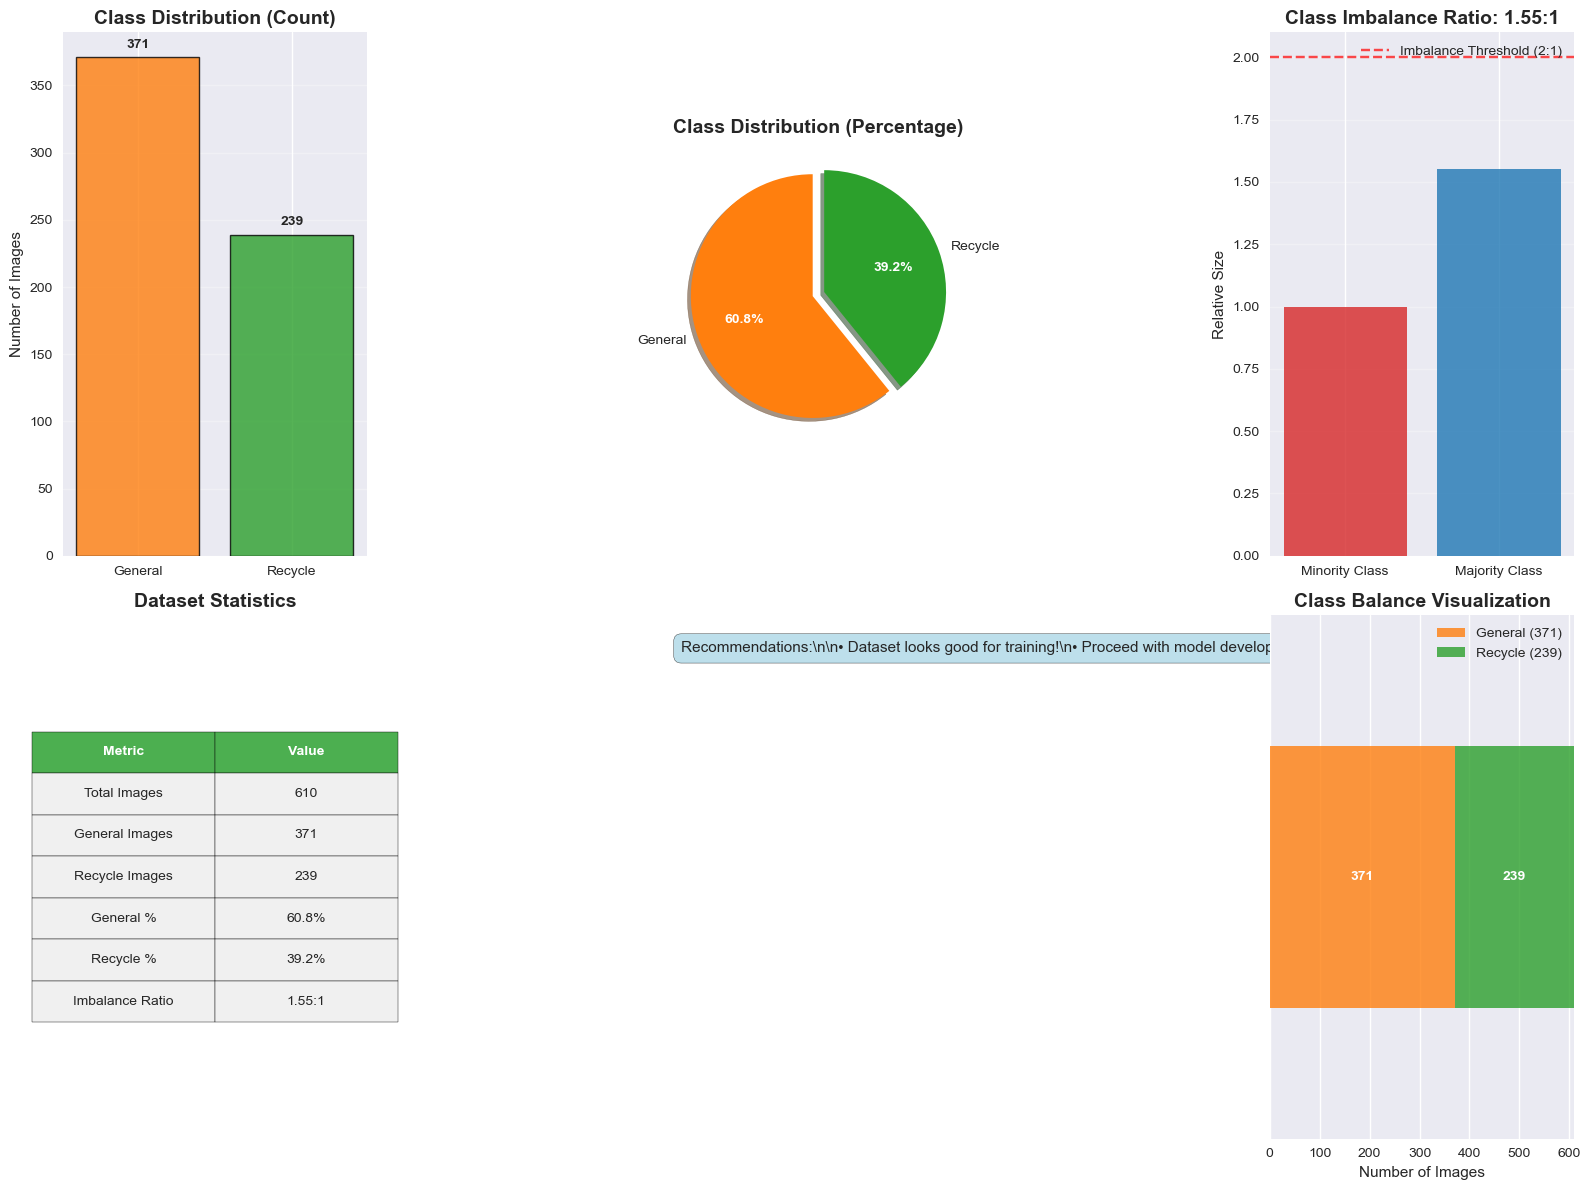

💾 Sample images saved as: smartbin_sample_images_20250613_101739.png


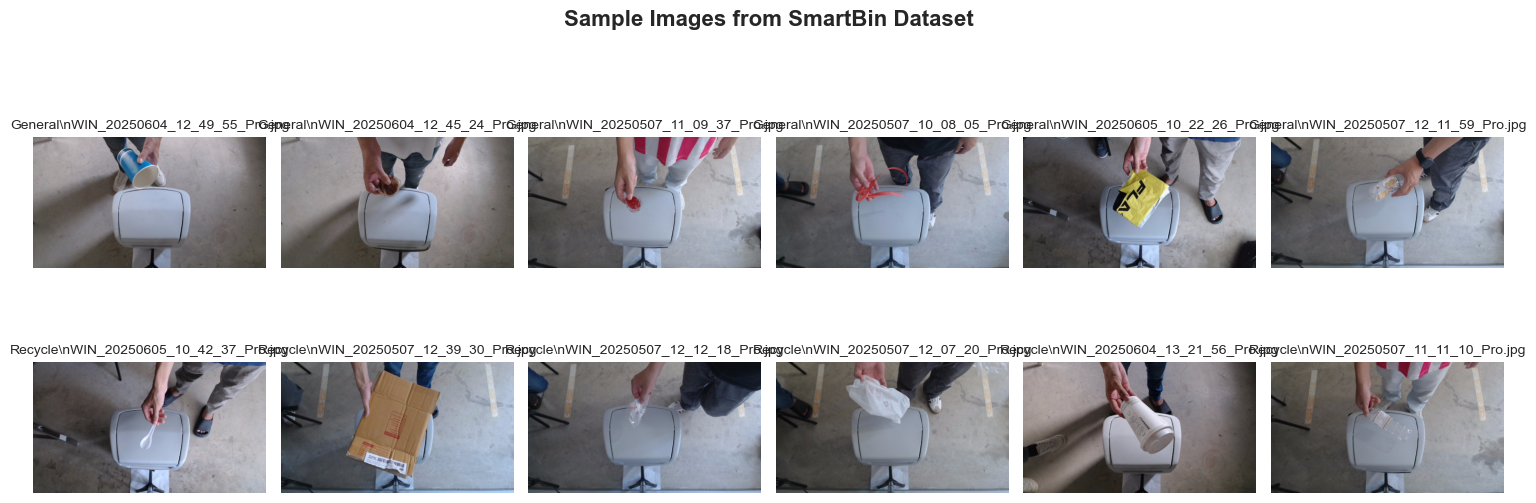

In [27]:
def create_eda_visualizations(data, save_images=True):
    """Create comprehensive EDA visualizations"""
    
    if data is None:
        print("No data to visualize.")
        return
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Bar Chart - Class Distribution
    ax1 = plt.subplot(2, 3, 1)
    classes = ['General', 'Recycle']
    counts = [data['general_count'], data['recycle_count']]
    colors = ['#ff7f0e', '#2ca02c']
    
    bars = ax1.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Pie Chart - Class Distribution
    ax2 = plt.subplot(2, 3, 2)
    percentages = [data['general_percentage'], data['recycle_percentage']]
    explode = (0.05, 0.05)  # explode both slices slightly
    
    wedges, texts, autotexts = ax2.pie(percentages, labels=classes, autopct='%1.1f%%',
                                      colors=colors, explode=explode, startangle=90,
                                      shadow=True)
    ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 3. Class Imbalance Visualization
    ax3 = plt.subplot(2, 3, 3)
    ratio_data = [1, data['imbalance_ratio']]
    ratio_labels = ['Minority Class', 'Majority Class']
    
    bars = ax3.bar(ratio_labels, ratio_data, color=['#d62728', '#1f77b4'], alpha=0.8)
    ax3.set_title(f'Class Imbalance Ratio: {data["imbalance_ratio"]:.2f}:1', 
                  fontsize=14, fontweight='bold')
    ax3.set_ylabel('Relative Size')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add horizontal line at ratio 2 (commonly considered imbalanced)
    ax3.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Imbalance Threshold (2:1)')
    ax3.legend()
    
    # 4. Dataset Statistics Table
    ax4 = plt.subplot(2, 3, 4)
    ax4.axis('off')
    
    stats_data = [
        ['Metric', 'Value'],
        ['Total Images', f"{data['total_images']:,}"],
        ['General Images', f"{data['general_count']:,}"],
        ['Recycle Images', f"{data['recycle_count']:,}"],
        ['General %', f"{data['general_percentage']:.1f}%"],
        ['Recycle %', f"{data['recycle_percentage']:.1f}%"],
        ['Imbalance Ratio', f"{data['imbalance_ratio']:.2f}:1"],
    ]
    
    table = ax4.table(cellText=stats_data[1:], colLabels=stats_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(stats_data)):
        for j in range(len(stats_data[0])):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    ax4.set_title('Dataset Statistics', fontsize=14, fontweight='bold')
    
    # 5. Recommendations
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')
    
    recommendations = []
    
    if data['total_images'] < 100:
        recommendations.append("• Consider collecting more data")
    elif data['total_images'] < 500:
        recommendations.append("• Dataset size is small, consider data augmentation")
    
    if data['imbalance_ratio'] > 2:
        recommendations.append("• Use stratified sampling for train/test split")
        recommendations.append("• Consider class balancing techniques")
        recommendations.append("• Use appropriate evaluation metrics (F1, AUC)")
    
    if data['general_count'] == 0 or data['recycle_count'] == 0:
        recommendations.append("• Missing one class - cannot train binary classifier")
    
    if not recommendations:
        recommendations.append("• Dataset looks good for training!")
        recommendations.append("• Proceed with model development")
    
    rec_text = "Recommendations:\\n\\n" + "\\n".join(recommendations)
    ax5.text(0.05, 0.95, rec_text, transform=ax5.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
            facecolor='lightblue', alpha=0.8))
    
    # 6. Class Balance Visual
    ax6 = plt.subplot(2, 3, 6)
    
    # Create a stacked bar to show balance
    bottom_val = 0
    colors_balance = ['#ff7f0e', '#2ca02c']
    labels_balance = ['General', 'Recycle']
    values_balance = [data['general_count'], data['recycle_count']]
    
    for i, (label, value, color) in enumerate(zip(labels_balance, values_balance, colors_balance)):
        ax6.barh(0, value, left=bottom_val, color=color, alpha=0.8, 
                label=f'{label} ({value})', height=0.5)
        
        # Add text in the middle of each segment
        if value > 0:
            ax6.text(bottom_val + value/2, 0, f'{value}', 
                    ha='center', va='center', fontweight='bold', color='white')
        bottom_val += value
    
    ax6.set_xlim(0, data['total_images'])
    ax6.set_ylim(-0.5, 0.5)
    ax6.set_xlabel('Number of Images')
    ax6.set_title('Class Balance Visualization', fontsize=14, fontweight='bold')
    ax6.legend(loc='upper right')
    ax6.set_yticks([])
    
    plt.tight_layout()
    
    # Save the figure
    if save_images:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'smartbin_eda_dashboard_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"💾 EDA dashboard saved as: {filename}")
    
    plt.show()
    return filename if save_images else None

def show_sample_images(data, n_samples=6, save_images=True):
    """Show sample images from each class"""
    
    if not data['general_files'] and not data['recycle_files']:
        print("No images to display.")
        return None
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    fig.suptitle('Sample Images from SmartBin Dataset', fontsize=16, fontweight='bold')
    
    # Show General samples
    if data['general_files']:
        general_samples = random.sample(data['general_files'], 
                                      min(n_samples, len(data['general_files'])))
        
        for i, img_path in enumerate(general_samples):
            if i < n_samples:
                try:
                    img = Image.open(img_path)
                    axes[0, i].imshow(img)
                    axes[0, i].set_title(f'General\\n{img_path.name}', fontsize=10)
                    axes[0, i].axis('off')
                except Exception as e:
                    axes[0, i].text(0.5, 0.5, 'Error loading', ha='center', va='center')
                    axes[0, i].axis('off')
    
    # Fill remaining General slots if needed
    for i in range(len(data['general_files']) if data['general_files'] else 0, n_samples):
        axes[0, i].axis('off')
        axes[0, i].text(0.5, 0.5, 'No image', ha='center', va='center')
    
    # Show Recycle samples
    if data['recycle_files']:
        recycle_samples = random.sample(data['recycle_files'], 
                                       min(n_samples, len(data['recycle_files'])))
        
        for i, img_path in enumerate(recycle_samples):
            if i < n_samples:
                try:
                    img = Image.open(img_path)
                    axes[1, i].imshow(img)
                    axes[1, i].set_title(f'Recycle\\n{img_path.name}', fontsize=10)
                    axes[1, i].axis('off')
                except Exception as e:
                    axes[1, i].text(0.5, 0.5, 'Error loading', ha='center', va='center')
                    axes[1, i].axis('off')
    
    # Fill remaining Recycle slots if needed
    for i in range(len(data['recycle_files']) if data['recycle_files'] else 0, n_samples):
        axes[1, i].axis('off')
        axes[1, i].text(0.5, 0.5, 'No image', ha='center', va='center')
    
    # Add row labels
    axes[0, 0].set_ylabel('General', fontsize=14, fontweight='bold', rotation=0, labelpad=40)
    axes[1, 0].set_ylabel('Recycle', fontsize=14, fontweight='bold', rotation=0, labelpad=40)
    
    plt.tight_layout()
    
    # Save the figure
    if save_images:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'smartbin_sample_images_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"💾 Sample images saved as: {filename}")
    
    plt.show()
    return filename if save_images else None

# Create EDA visualizations and save them
if dataset_info:
    eda_filename = create_eda_visualizations(dataset_info, save_images=True)
    samples_filename = show_sample_images(dataset_info, n_samples=6, save_images=True)


In [28]:
class SmartBinClassifier:
    def __init__(self, dataset_path="F:\\SmartBin\\dataset", img_size=(128, 128)):
        """
        Initialize SmartBin Logistic Regression Classifier
        
        Args:
            dataset_path (str): Path to dataset directory
            img_size (tuple): Target image size for preprocessing
        """
        self.dataset_path = Path(dataset_path)
        self.general_dir = self.dataset_path / "General"
        self.recycle_dir = self.dataset_path / "Recycle"
        self.img_size = img_size
        self.image_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}
        
        # Model components
        self.model = None
        self.scaler = None
        self.pipeline = None
        self.class_names = ['General', 'Recycle']
        
        # Data storage
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        # Results storage
        self.results = {}
        
    def load_image(self, image_path):
        """Load and preprocess a single image"""
        try:
            # Load image
            img = Image.open(image_path).convert('RGB')
            
            # Resize image
            img = img.resize(self.img_size)
            
            # Convert to array and normalize
            img_array = np.array(img) / 255.0
            
            # Flatten image
            img_flattened = img_array.flatten()
            
            return img_flattened
            
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return None
    
    def load_dataset(self, verbose=True):
        """Load the complete dataset"""
        if verbose:
            print("Loading SmartBin Dataset...")
            print("=" * 40)
        
        images = []
        labels = []
        
        # Load General images (label = 0)
        if self.general_dir.exists():
            general_count = 0
            for img_file in self.general_dir.iterdir():
                if img_file.is_file() and img_file.suffix.lower() in self.image_exts:
                    img_data = self.load_image(img_file)
                    if img_data is not None:
                        images.append(img_data)
                        labels.append(0)
                        general_count += 1
            
            if verbose:
                print(f"✅ General images loaded: {general_count}")
        else:
            print(f"❌ General directory not found: {self.general_dir}")
        
        # Load Recycle images (label = 1)
        if self.recycle_dir.exists():
            recycle_count = 0
            for img_file in self.recycle_dir.iterdir():
                if img_file.is_file() and img_file.suffix.lower() in self.image_exts:
                    img_data = self.load_image(img_file)
                    if img_data is not None:
                        images.append(img_data)
                        labels.append(1)
                        recycle_count += 1
            
            if verbose:
                print(f"✅ Recycle images loaded: {recycle_count}")
        else:
            print(f"❌ Recycle directory not found: {self.recycle_dir}")
        
        if not images:
            raise ValueError("No images found! Check your dataset directories.")
        
        # Convert to numpy arrays
        self.X = np.array(images)
        self.y = np.array(labels)
        
        if verbose:
            print(f"\\n📊 Dataset Summary:")
            print(f"Total images: {len(self.X)}")
            print(f"General: {np.sum(self.y == 0)} ({np.sum(self.y == 0)/len(self.y)*100:.1f}%)")
            print(f"Recycle: {np.sum(self.y == 1)} ({np.sum(self.y == 1)/len(self.y)*100:.1f}%)")
            print(f"Feature dimensions: {self.X.shape[1]} (flattened {self.img_size[0]}x{self.img_size[1]}x3)")
        
        return self.X, self.y

print("✅ SmartBinClassifier class defined successfully!")


✅ SmartBinClassifier class defined successfully!


In [29]:
# Add training and evaluation methods to SmartBinClassifier

def split_data(self, test_size=0.2, random_state=42, stratify=True):
    """Split data into train and test sets"""
    if self.X is None or self.y is None:
        raise ValueError("Data not loaded. Call load_dataset() first.")
    
    stratify_param = self.y if stratify else None
    
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=stratify_param
    )
    
    print(f"\\n🔄 Data Split:")
    print(f"Training set: {len(self.X_train)} samples")
    print(f"Test set: {len(self.X_test)} samples")
    print(f"Train split - General: {np.sum(self.y_train == 0)}, Recycle: {np.sum(self.y_train == 1)}")
    print(f"Test split - General: {np.sum(self.y_test == 0)}, Recycle: {np.sum(self.y_test == 1)}")
    
    return self.X_train, self.X_test, self.y_train, self.y_test

def train_model(self, scaler_type='standard', C=1.0, max_iter=1000):
    """Train the logistic regression model"""
    if self.X_train is None:
        raise ValueError("Data not split. Call split_data() first.")
    
    # Choose scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type must be 'standard' or 'minmax'")
    
    # Create logistic regression model
    model = LogisticRegression(
        C=C, 
        max_iter=max_iter, 
        random_state=42,
        class_weight='balanced'  # Handle class imbalance
    )
    
    # Create pipeline
    self.pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', model)
    ])
    
    print(f"\\n🚀 Training Logistic Regression Model...")
    print(f"🔧 Pipeline: {scaler_type} scaler + LogisticRegression(C={C})")
    
    # Train the pipeline
    self.pipeline.fit(self.X_train, self.y_train)
    
    print("✅ Model training completed!")
    
    return self.pipeline

def evaluate_model(self):
    """Comprehensive model evaluation"""
    if self.pipeline is None:
        raise ValueError("Model not trained. Call train_model() first.")
    
    print("\\n📊 Model Evaluation")
    print("=" * 50)
    
    # Make predictions
    y_train_pred = self.pipeline.predict(self.X_train)
    y_test_pred = self.pipeline.predict(self.X_test)
    y_test_proba = self.pipeline.predict_proba(self.X_test)[:, 1]
    
    # Calculate metrics
    train_acc = accuracy_score(self.y_train, y_train_pred)
    test_acc = accuracy_score(self.y_test, y_test_pred)
    precision = precision_score(self.y_test, y_test_pred)
    recall = recall_score(self.y_test, y_test_pred)
    f1 = f1_score(self.y_test, y_test_pred)
    auc = roc_auc_score(self.y_test, y_test_proba)
    
    # Store results
    self.results = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc,
        'y_test': self.y_test,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }
    
    # Print results
    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")
    
    # Classification report
    print(f"\\n📋 Classification Report:")
    print(classification_report(self.y_test, y_test_pred, 
                              target_names=self.class_names))
    
    return self.results

def cross_validate(self, cv=5):
    """Perform cross-validation"""
    if self.pipeline is None:
        raise ValueError("Model not trained. Call train_model() first.")
    
    print(f"\\n🔄 Performing {cv}-fold Cross Validation...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(self.pipeline, self.X_train, self.y_train, 
                               cv=cv, scoring='accuracy')
    
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return cv_scores

def plot_results(self, save_images=True):
    """Create comprehensive result visualizations"""
    if not self.results:
        raise ValueError("Model not evaluated. Call evaluate_model() first.")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('SmartBin Logistic Regression Results', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(self.results['y_test'], self.results['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=self.class_names, yticklabels=self.class_names,
               ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_ylabel('True Label')
    axes[0,0].set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(self.results['y_test'], self.results['y_test_proba'])
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
                  label=f'ROC curve (AUC = {self.results["auc_score"]:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Metrics Bar Chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    values = [self.results['test_accuracy'], self.results['precision'],
             self.results['recall'], self.results['f1_score'], self.results['auc_score']]
    
    bars = axes[1,0].bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    axes[1,0].set_title('Model Performance Metrics')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_ylim([0, 1])
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Prediction Distribution
    axes[1,1].hist(self.results['y_test_proba'][self.results['y_test'] == 0], 
                  bins=20, alpha=0.7, label='General', color='#ff7f0e')
    axes[1,1].hist(self.results['y_test_proba'][self.results['y_test'] == 1], 
                  bins=20, alpha=0.7, label='Recycle', color='#2ca02c')
    axes[1,1].set_xlabel('Predicted Probability (Recycle)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Prediction Probability Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    if save_images:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'smartbin_model_results_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"💾 Model results saved as: {filename}")
        self.results_filename = filename
    
    plt.show()
    return filename if save_images else None

def predict_image(self, image_path):
    """Predict class for a single image"""
    if self.pipeline is None:
        raise ValueError("Model not trained. Call train_model() first.")
    
    # Load and preprocess image
    img_data = self.load_image(image_path)
    if img_data is None:
        return None, None
    
    # Make prediction
    prediction = self.pipeline.predict(img_data.reshape(1, -1))[0]
    probability = self.pipeline.predict_proba(img_data.reshape(1, -1))[0]
    
    class_name = self.class_names[prediction]
    confidence = max(probability) * 100
    
    return class_name, confidence

def save_model(self, filepath=None):
    """Save the trained model"""
    if self.pipeline is None:
        raise ValueError("Model not trained. Call train_model() first.")
    
    if filepath is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"smartbin_logistic_model_{timestamp}.pkl"
    
    joblib.dump(self.pipeline, filepath)
    print(f"✅ Model saved to: {filepath}")
    
    return filepath

# Bind methods to the class
SmartBinClassifier.split_data = split_data
SmartBinClassifier.train_model = train_model
SmartBinClassifier.evaluate_model = evaluate_model
SmartBinClassifier.cross_validate = cross_validate
SmartBinClassifier.plot_results = plot_results
SmartBinClassifier.predict_image = predict_image
SmartBinClassifier.save_model = save_model

print("✅ All methods added to SmartBinClassifier!")


✅ All methods added to SmartBinClassifier!


In [30]:
# Initialize the SmartBin classifier
classifier = SmartBinClassifier(img_size=(128, 128))

print("🎯 SmartBin Classifier initialized!")
print("📊 Ready to load data and train model!")


🎯 SmartBin Classifier initialized!
📊 Ready to load data and train model!


In [31]:
# Load the dataset
try:
    X, y = classifier.load_dataset()
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please make sure your dataset directories exist and contain images.")


Loading SmartBin Dataset...
✅ General images loaded: 371
✅ Recycle images loaded: 239
\n📊 Dataset Summary:
Total images: 610
General: 371 (60.8%)
Recycle: 239 (39.2%)
Feature dimensions: 49152 (flattened 128x128x3)
✅ Dataset loaded successfully!


In [32]:
# Split data into training and testing sets
classifier.split_data(test_size=0.2, stratify=True)

# Train the logistic regression model
classifier.train_model(scaler_type='standard', C=1.0, max_iter=1000)


\n🔄 Data Split:
Training set: 488 samples
Test set: 122 samples
Train split - General: 297, Recycle: 191
Test split - General: 74, Recycle: 48
\n🚀 Training Logistic Regression Model...
🔧 Pipeline: standard scaler + LogisticRegression(C=1.0)
✅ Model training completed!


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [33]:
# Perform cross-validation
classifier.cross_validate(cv=5)

# Evaluate the model comprehensively
results = classifier.evaluate_model()


\n🔄 Performing 5-fold Cross Validation...
Cross-validation scores: [0.6122449  0.6122449  0.58163265 0.6185567  0.51546392]
Mean CV accuracy: 0.5880 (+/- 0.0770)
\n📊 Model Evaluation
Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.6311 (63.11%)
Precision: 0.5306
Recall: 0.5417
F1-Score: 0.5361
AUC Score: 0.6602
\n📋 Classification Report:
              precision    recall  f1-score   support

     General       0.70      0.69      0.69        74
     Recycle       0.53      0.54      0.54        48

    accuracy                           0.63       122
   macro avg       0.61      0.62      0.61       122
weighted avg       0.63      0.63      0.63       122



💾 Model results saved as: smartbin_model_results_20250613_101808.png


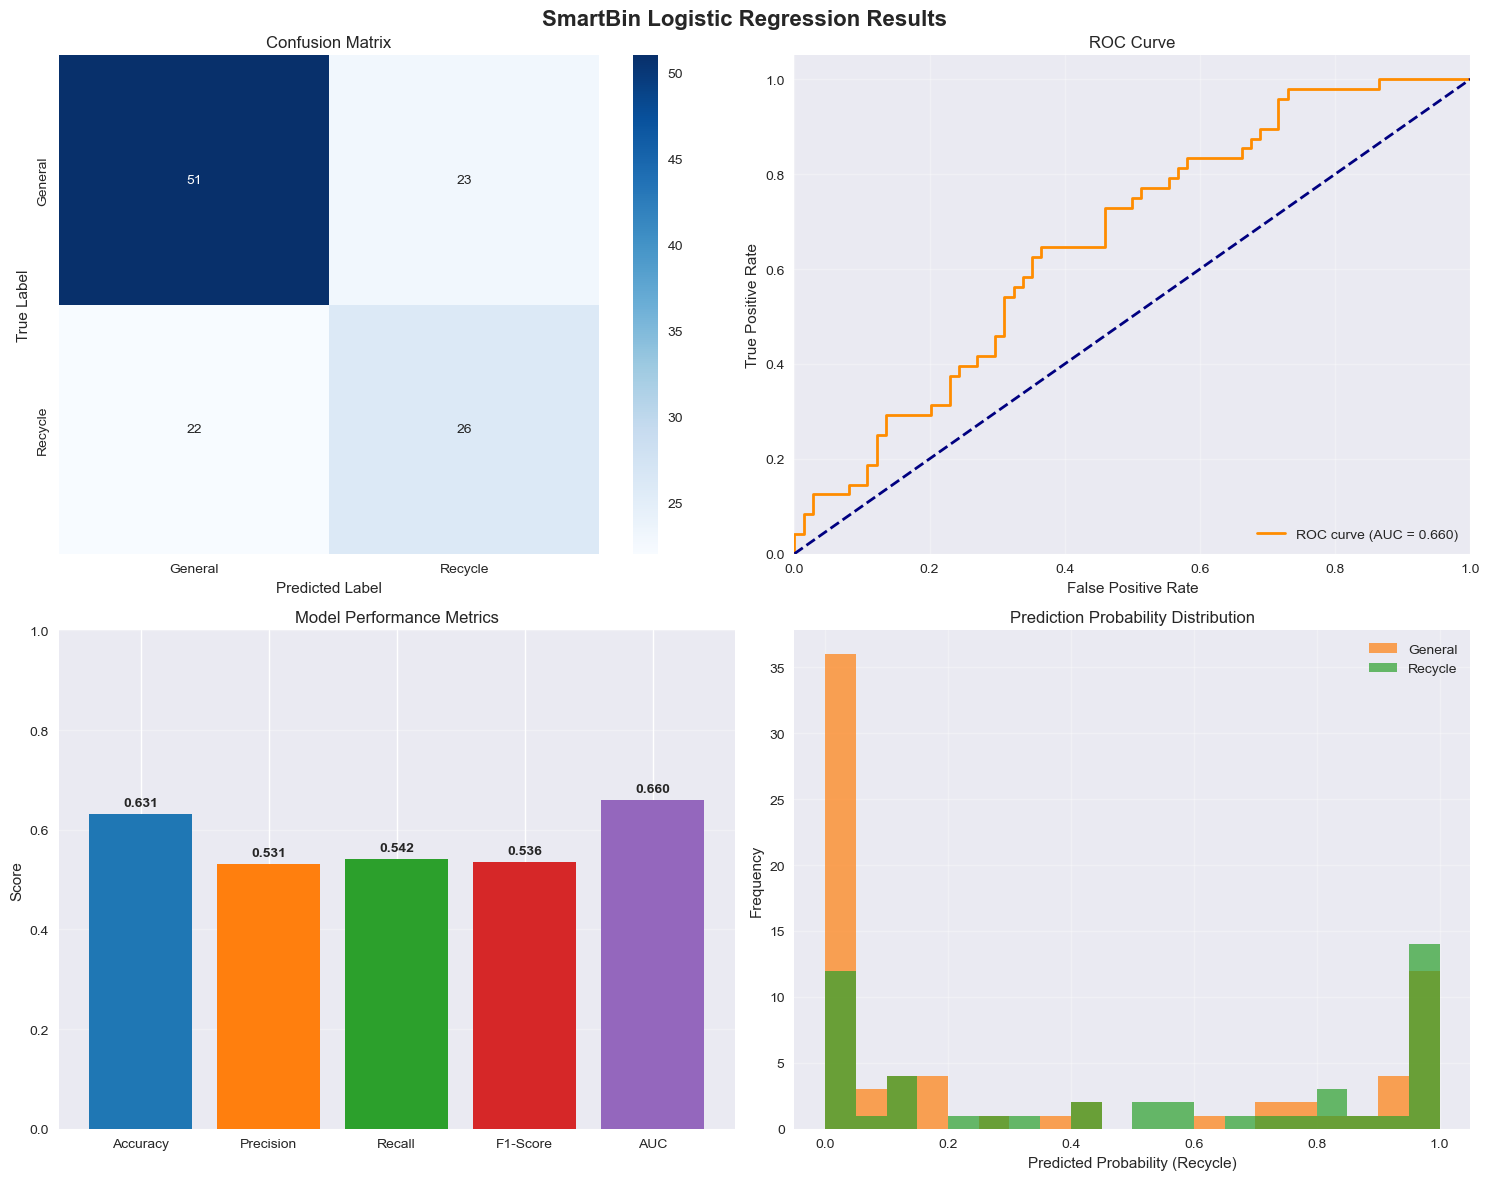

In [34]:
# Create comprehensive result visualizations and save them
results_filename = classifier.plot_results(save_images=True)


In [35]:
# Save the trained model
model_path = classifier.save_model()

print(f"\\n🎉 SmartBin Classification completed successfully!")
print(f"💾 Model saved as: {model_path}")

# Example of how to predict on a single image
# Uncomment and modify the path below to test with your own image
# 
# example_image_path = r"F:\\SmartBin\\dataset\\General\\example_image.jpg"
# if Path(example_image_path).exists():
#     class_name, confidence = classifier.predict_image(example_image_path)
#     print(f"\\n🔍 Single Image Prediction:")
#     print(f"Image: {example_image_path}")
#     print(f"Prediction: {class_name}")
#     print(f"Confidence: {confidence:.2f}%")
# else:
#     print("\\n💡 To test single image prediction:")
#     print("1. Uncomment the code above")
#     print("2. Replace 'example_image.jpg' with your actual image file")
#     print("3. Run the cell again")

print("\\n📋 Summary:")
print("✅ Dataset analyzed with comprehensive EDA")
print("✅ Logistic regression model trained and evaluated")
print("✅ Cross-validation performed")
print("✅ Results visualized with confusion matrix, ROC curve, and metrics")
print("✅ Model saved for future use")

print("\\n📸 Generated Files:")
print(f"📊 EDA Dashboard: {eda_filename}")
print(f"🖼️  Sample Images: {samples_filename}")
print(f"📈 Model Results: {results_filename}")
print(f"🤖 Trained Model: {model_path}")

print("\\n🚀 Your SmartBin classifier is ready for production!")


✅ Model saved to: smartbin_logistic_model_20250613_101809.pkl
\n🎉 SmartBin Classification completed successfully!
💾 Model saved as: smartbin_logistic_model_20250613_101809.pkl
\n📋 Summary:
✅ Dataset analyzed with comprehensive EDA
✅ Logistic regression model trained and evaluated
✅ Cross-validation performed
✅ Results visualized with confusion matrix, ROC curve, and metrics
✅ Model saved for future use
\n📸 Generated Files:
📊 EDA Dashboard: smartbin_eda_dashboard_20250613_101737.png
🖼️  Sample Images: smartbin_sample_images_20250613_101739.png
📈 Model Results: smartbin_model_results_20250613_101808.png
🤖 Trained Model: smartbin_logistic_model_20250613_101809.pkl
\n🚀 Your SmartBin classifier is ready for production!
